In [ ]:
!pip install sentencepiece
!pip install unidecode
!pip install contractions

     |████████████████████████████████| 1.2MB 8.4MB/s 
     |████████████████████████████████| 245kB 8.7MB/s 
     |████████████████████████████████| 317kB 6.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=aefd44ce233852c7b439b8d39688041081a53acd7713e6555c30b9fb8b5a4687
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
from bs4 import BeautifulSoup 
import unidecode
import contractions
from gensim.parsing.preprocessing import remove_stopwords
import re
from nltk.stem.porter import PorterStemmer

def preprocessing(text):
  ### Removed HTML Tags - <> ###
  text = BeautifulSoup(text, 'html.parser')
  text = text.get_text(separator=' ')
  ### Convert Accented Characters ###
  text = unidecode.unidecode(text)
  ### Expand Contractions - don't ###
  text = contractions.fix(text)
  ### Removed Stopwords ###
  text = remove_stopwords(text)
  ### Removed URL ###
  text = re.sub(r'http\S+', '', text)
  ### Removed All Irrelevant Characters ###
  text = re.sub('[^a-zA-Z]', ' ', text)
  ### Convert All Characters into lowercase  ###
  text = text.lower()
  ### Removed not less than 2 words ###
  text = [word for word in text.split() if len(word) > 3]
  ### Stemming ###
  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]
  ### Concated ###
  cleaned_text = ' '.join(text)
  
  return cleaned_text

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adagrad, SGD
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow_addons as tfa

import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'
# module_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
# train = pd.read_csv("/content/drive/MyDrive/SIGNATE/DATASET/train.csv")
# test = pd.read_csv("/content/drive/MyDrive/SIGNATE/DATASET/test.csv")
# # train['html_content'] = train['html_content'].apply(preprocessing)
# # test['html_content'] = test['html_content'].apply(preprocessing)
# submission = pd.read_csv("/content/drive/MyDrive/SIGNATE/DATASET/sample_submit.csv")

In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/SIGNATE/DATASET/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/SIGNATE/DATASET/test.csv')

Y_train = df_train['state'].astype(int).values
df_train = df_train.drop('state', axis=1)
test_id = df_test['id']

train_html = df_train['html_content'].apply(preprocessing)
test_html = df_test['html_content'].apply(preprocessing)
data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0).apply(preprocessing)

# train_html = df_train['html_content'].values
# test_html = df_test['html_content'].values
# data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0)

df_train = df_train.drop('html_content', axis=1)
df_test = df_test.drop('html_content', axis=1)
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

df = pd.concat([df_train, df_test], axis=0)

print('train_html shape: {0}'.format(train_html.shape))
print('test_html shape: {0}'.format(test_html.shape))
print('data_html shape: {0}'.format(data_html.shape))

train_html shape: (10545,)
test_html shape: (10544,)
data_html shape: (21089,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

train_data = np.empty((len(df_train), 0), int)
test_data = np.empty((len(df_test), 0), int)

for column in df.columns:
  one_hot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoder.fit(df[column].values.reshape(-1, 1))
  train_temp = one_hot_encoder.transform(df_train[column].values.reshape(-1, 1))
  test_temp = one_hot_encoder.transform(df_test[column].values.reshape(-1, 1))
  train_data = np.concatenate([train_data, train_temp], axis=1)
  test_data = np.concatenate([test_data, test_temp], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 359)
test_data: (10544, 359)


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
MAX_LEN = 300
EPOCHS = 5
BATCH_SIZE = 32

In [ ]:
train_input = bert_encode(train_html, tokenizer, max_len=MAX_LEN)
test_input = bert_encode(test_html, tokenizer, max_len=MAX_LEN)

In [ ]:
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")
_, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]

nn_input = Input(shape=(359,))
y = Dense(32, activation='relu')(nn_input)
nn_model = Dense(32, activation='relu')(y)

concatenated = concatenate([clf_output, nn_model], axis=-1)
output = Dense(1, activation='sigmoid')(concatenated)

model = Model([input_word_ids, input_mask, segment_ids, nn_input], output)

model.compile(optimizer=tfa.optimizers.RectifiedAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5)), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

# BERT model

|Input size|EPOCHS|DATASET|loss|accuracy|f1 score|val_loss|val_accuracy|validation f1 score|Public Leaderboard|Elapsed time|Predicted time|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|160|1|No cleaned|0.6172|0.6608||0.5627|0.7079||0.7510|||
|160|1|cleaned|0.6530|0.6173|0.5354|0.5989|0.6714|0.7044|0.7103|4.3 hours|1.88 hours|
|160|10|No cleaned|0|0|0|0|0||0|F|F|
|160|10|cleaned|0|0|0|0|0|F|0|F|F|

# Evaluation

|MAX_LEN|EPOCHS|BATCH_SIZE|Optimizer|learning rate|Elapsed time|validation f1 score|Public Leaderboard|Ensembled Public Leaderboard|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|160|10|16|Adam|1e-5|52 minuites|0.7310|0.7345|0.7599|
|100|5|32|Adam|1e-5|17 minuites|0.7151|0|0|
|100|5|32|SGD|1e-5|17 minuites|0.5827|0|0|
|100|5|32|RSMprop|1e-5|17 minuites|0.6978|0|0|
|100|5|32|Adam|1e-3|17 minuites|0.6625|0|0|
|100|5|32|Adam|1e-4|17 minuites|0.6625|0|0|
|100|5|32|SDG|1e-4|17 minuites|0.5887|0|0|
|200|5|32|Adam|1e-5|33 minuites|0.7424|0|0|
|300|5|32|Adam|1e-5|50 minuites|0.7499|0.693023|0|
|400|5|32|Adam|1e-5|0|0|0|0|
|500|5|32|Adam|1e-5|0|0|0|0|
|0|0|0|0|0|0|0|0|0|

<br>

- html_contentの前処理はしない方が精度が高い

- BERT(Large)はメモリ不足に陥る

- 入力サイズが大きいほど精度は良い気がする

- Adagradは使用不可

In [ ]:
import keras
import time

# callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SIGNATE/DATASET/BERT.h5', monitor='val_f1_score', save_best_only=True,)]

start = time.time()

# history = model.fit([train_input, train_data], Y_train, validation_split=0.2, callbacks=callbacks_list, epochs=EPOCHS, batch_size=BATCH_SIZE)
history = model.fit([train_input, train_data], Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

elapsed_time = time.time() - start

print('elapsed time: {0} minuites'.format(elapsed_time / 60))

Epoch 1/5
264/264 [==============================] - 647s 2s/step - loss: 0.6140 - binary_accuracy: 0.6678 - f1_score: 0.6425 - val_loss: 0.5248 - val_binary_accuracy: 0.7487 - val_f1_score: 0.7691
Epoch 2/5
264/264 [==============================] - 633s 2s/step - loss: 0.4439 - binary_accuracy: 0.7977 - f1_score: 0.8023 - val_loss: 0.5280 - val_binary_accuracy: 0.7454 - val_f1_score: 0.7490
Epoch 3/5
264/264 [==============================] - 633s 2s/step - loss: 0.2444 - binary_accuracy: 0.9082 - f1_score: 0.9084 - val_loss: 0.6796 - val_binary_accuracy: 0.7330 - val_f1_score: 0.7430
Epoch 4/5
264/264 [==============================] - 634s 2s/step - loss: 0.0747 - binary_accuracy: 0.9763 - f1_score: 0.9758 - val_loss: 0.8934 - val_binary_accuracy: 0.7288 - val_f1_score: 0.7296
Epoch 5/5
264/264 [==============================] - 634s 2s/step - loss: 0.0331 - binary_accuracy: 0.9886 - f1_score: 0.9884 - val_loss: 1.0347 - val_binary_accuracy: 0.7387 - val_f1_score: 0.7418
elapsed ti

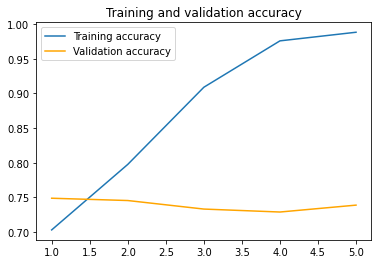

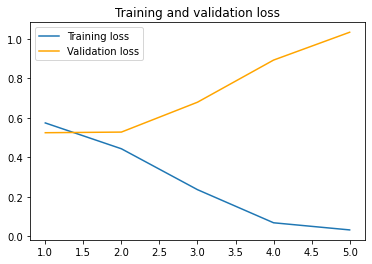

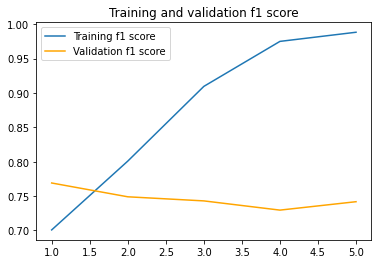

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, EPOCHS+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [ ]:
import numpy as np
from keras.models import load_model

# model = load_model('/content/drive/MyDrive/SIGNATE/DATASET/BERT.h5', custom_objects={'KerasLayer': hub.KerasLayer, 'f1_score': f1_score})

predicted = model.predict([test_input, test_data])

start = time.time()

# df_bert = pd.concat([test_id, pd.DataFrame(predicted, columns=['predicted'])], axis=1)
# df_bert.to_csv('/content/drive/MyDrive/SIGNATE/DATASET/BERT.csv', index=False, header=False)

df_sub = pd.concat([test_id, pd.DataFrame(np.round(predicted), columns=['predicted']).astype(int)], axis=1)

elapsed_time = time.time() - start

print('elapsed time: {0} minuites'.format(elapsed_time / 60))
print('df_sub shape: {0}'.format(df_sub.shape))

# df_sub.to_csv('submission.csv', index=False, header=False)
df_sub.to_csv('/content/drive/MyDrive/SIGNATE/DATASET/submission.csv', index=False, header=False)

df_sub.head()

elapsed time: 4.0026505788167316e-05 minuites
df_sub shape: (10544, 2)


,id,predicted
0,10545,0
1,10546,1
2,10547,1
3,10548,0
4,10549,1


# JavaScript

```javascript
function ClickConnect(){
 
console.log("Working"); 
document.querySelector("#comments > span").click() 
}
setInterval(ClickConnect,500000)
```